<a href="https://colab.research.google.com/github/raymond92928/AIclass/blob/main/GAN/DCGAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo DCGAN, create handwrite number
### reference: [DCGAN-MNIST-pytorch](https://github.com/Ksuryateja/DCGAN-MNIST-pytorch)

## install module

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 kB 7.3 MB/s eta 0:00:00


## Grant access to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/MyDrive/Colab

 1.png
 Colab
 CopySharedFloder
'New Text Document.txt'
 PUICHING
 python_coding
 Test.py
 timetable.pdf
'Untitled document.gdoc'
'Untitled presentation.gslides'
 上課圖片
 加法原理和乘法原理ThePrincipleOfAdditionAndMultiplication.pdf
'答題紙 (1).7z'
 答題紙.7z
 駝背機


In [ ]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision import utils as vutils

## Parameter setting

In [ ]:
PATH_DATASETS = "" # Default path
BATCH_SIZE = 64  # batch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

## Load MNIST handwritten Arabic numeral data

In [ ]:
# 轉換
transform=transforms.Compose([
   transforms.Resize(28),
   transforms.ToTensor(),
   transforms.Normalize((0.5,), (0.5,)),
])

# 下載 MNIST 手寫阿拉伯數字 訓練資料
dataset = MNIST(PATH_DATASETS, train=True, download=True,
                 transform=transform)
dataloader = torch.utils.data.DataLoader(dataset
                   , batch_size=BATCH_SIZE, shuffle=True)

# 訓練資料的維度
print(dataset.data.shape)

100%|██████████| 9912422/9912422 [00:00<00:00, 171235806.08it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 27675506.93it/s]


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26552808.50it/s]


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18861909.67it/s]


Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw

torch.Size([60000, 28, 28])


## Define neural network parameters

In [ ]:
nz = 100  # 生成神經網路雜訊維度
ngf = 64  # 生成神經網路濾波器個數
ndf = 64  # 判別神經網路濾波器個數

## Neural network weight initial value

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02) # 卷積層權重初始值
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02) # Batch Normalization 層權重初始值
        m.bias.data.fill_(0)

## Define generative neural network

In [ ]:
class Generator(nn.Module):
    def __init__(self, nc=1, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, kernel_size=1,
                               stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output

netG = Generator().to(device)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    (13): Tanh()
  )
)

## Define discriminative neural network

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

## Set loss function and optimizer

In [ ]:
# 設定損失函數
criterion = nn.BCELoss()

# 設定優化器(optimizer)
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

## Perform model training

In [ ]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1.0
fake_label = 0.0
niter = 25
# 模型訓練
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ########################################################
        # (1) 判別神經網路: maximize log(D(x)) + log(1 - D(G(z)))
        #######################################################
        # 訓練真實資料
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # 訓練假資料
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ########################################################
        # (2) 判別神經網路: maximize log(D(G(z)))
        #######################################################
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        if i % 200 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                   % (epoch+1, niter, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            vutils.save_image(real_cpu,'/content/gdrive/MyDrive/Colab/gan_output/real_samples.png' ,normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),'/content/gdrive/MyDrive/Colab/gan_output/fake_samples_epoch_%03d.png'
                              % (epoch), normalize=True)
    torch.save(netG.state_dict(), '/content/gdrive/MyDrive/Colab/gan_weights/netG_epoch_%d.pth' % (epoch))
    torch.save(netD.state_dict(), '/content/gdrive/MyDrive/Colab/gan_weights/netD_epoch_%d.pth' % (epoch))

[1/25][0/938] Loss_D: 0.9175 Loss_G: 1.9695 D(x): 0.9080 D(G(z)): 0.5323 / 0.1620
[1/25][200/938] Loss_D: 0.6096 Loss_G: 1.5033 D(x): 0.6259 D(G(z)): 0.0804 / 0.2502
[1/25][400/938] Loss_D: 0.3098 Loss_G: 3.0089 D(x): 0.8859 D(G(z)): 0.1592 / 0.0634
[1/25][600/938] Loss_D: 0.8179 Loss_G: 2.8364 D(x): 0.9012 D(G(z)): 0.4751 / 0.0728
[1/25][800/938] Loss_D: 0.9105 Loss_G: 0.7907 D(x): 0.4778 D(G(z)): 0.0877 / 0.4747
[2/25][0/938] Loss_D: 0.7518 Loss_G: 1.4892 D(x): 0.6695 D(G(z)): 0.2583 / 0.2557
[2/25][200/938] Loss_D: 0.7615 Loss_G: 1.4877 D(x): 0.6907 D(G(z)): 0.2934 / 0.2490
[2/25][400/938] Loss_D: 0.8690 Loss_G: 1.4336 D(x): 0.6388 D(G(z)): 0.3076 / 0.2562
[2/25][600/938] Loss_D: 0.7901 Loss_G: 1.3108 D(x): 0.6303 D(G(z)): 0.2343 / 0.2994
[2/25][800/938] Loss_D: 0.8969 Loss_G: 1.3197 D(x): 0.6823 D(G(z)): 0.3572 / 0.2920
[3/25][0/938] Loss_D: 0.8261 Loss_G: 1.4577 D(x): 0.6219 D(G(z)): 0.2480 / 0.2680
[3/25][200/938] Loss_D: 0.7758 Loss_G: 1.5789 D(x): 0.7500 D(G(z)): 0.3479 / 0.236

## new data forecast

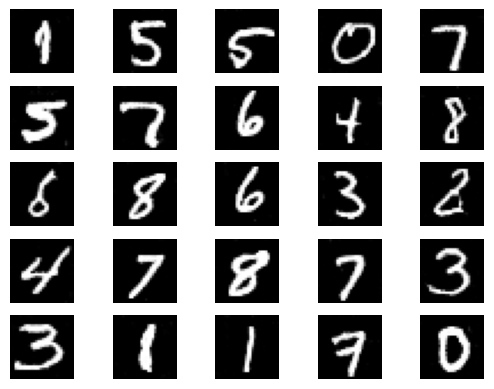

In [ ]:
import matplotlib.pyplot as plt

batch_size = 25
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1).to(device)
fake_images = netG(fixed_noise)
fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
R, C = 5, 5
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.axis('off')
    plt.imshow(fake_images_np[i], cmap='gray')
plt.show()

## Create GIF

In [ ]:
# 安裝產生 GIF 檔的套件
!pip install -q imageio

In [ ]:
import imageio
import glob

# 產生 GIF 檔
anim_file = '/content/gdrive/MyDrive/Colab/gan_output/dcgan.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/gdrive/MyDrive/Colab/gan_output/fake_samples*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

<ipython-input-32-5a4fa8a79f4c>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


<img src="./gan_output/dcgan.gif" align="left">